
<h1 id="Load-packages">Load packages<a class="anchor-link" href="#Load-packages">¶</a></h1>


In [1]:

import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline




<h1 id="MNIST-train,-test-dataset-가져오기">MNIST train, test dataset 가져오기<a class="anchor-link" href="#MNIST-train,-test-dataset-가져오기">¶</a></h1>


In [2]:

# "": 현재 폴더에 MINIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), #train 용으로 쓰겠다.
                      target_transform=None, download=True)
mnist_test=dset.MNIST("",train=False,transform=transforms.ToTensor(), #test 용으로 쓰겠다
                      target_transform=None, download=True)




<h1 id="대략적인-데이터-형태">대략적인 데이터 형태<a class="anchor-link" href="#대략적인-데이터-형태">¶</a></h1>


In [3]:

print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이: ", len(mnist_test)

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) #0번째 데이터
print "image data 형태: ", image.size()
print "label:", label

#그리기
img = image.numpy() #image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()



SyntaxError: invalid syntax (<ipython-input-3-2197e03f1970>, line 2)


<h1 id="MNIST-data-띄워보기">MNIST data 띄워보기<a class="anchor-link" href="#MNIST-data-띄워보기">¶</a></h1>


5
torch.Size([1, 28, 28])
5


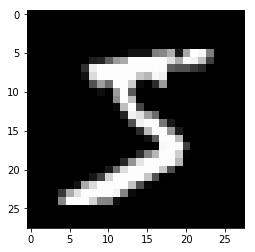

0


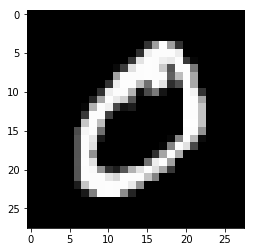

4


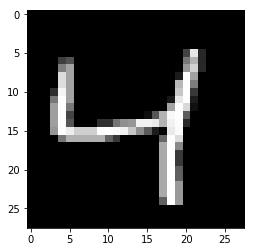

In [4]:

print(mnist_train[0][1]) # label
print(mnist_train[0][0].size()) # image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show()




<h1 id="convolution-하나-씌워보기">convolution 하나 씌워보기<a class="anchor-link" href="#convolution-하나-씌워보기">¶</a></h1>


torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


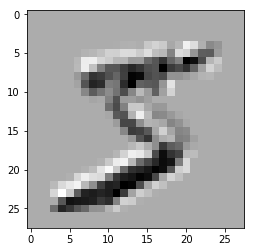

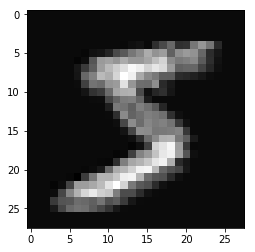

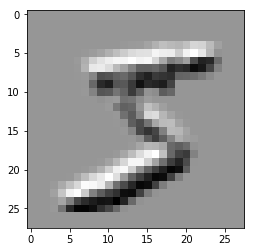

In [6]:

# mnist 의 첫 번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor 의 사이즈 조절. -1: 해당 차원 확장시켜라
# [1, 28, 28] -> [1. 1. 28.28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

# convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
# image 에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()




<h1 id="CNN-만들기">CNN 만들기<a class="anchor-link" href="#CNN-만들기">¶</a></h1><h3 id="train,-test-data-가져오기">train, test data 가져오기<a class="anchor-link" href="#train,-test-data-가져오기">¶</a></h3>


In [7]:

import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10 # 1000



In [8]:

# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,    # mnist_train 를 트레인 시키자
                                          shuffle=True, num_workers=2,
                                          drop_last=True) # batch_size 만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         drop_last=True)



In [9]:

class CNN(nn.Module):  # nn.Module 상속받음
    def __init__(self):
        super(CNN,self).__init__()  # 28 x 28
        self.layer=nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(16,32,3,padding=2), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 28 x 28 -> 14 x 14
            
            nn.Conv2d(32,64,5,padding=2),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 14 x 14 -> 7 x 7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )

        
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        return out

model=CNN() #.cuda()



In [10]:

# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)



torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [11]:

# loss function, optimizer 선언
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)




<h1 id="optimization">optimization<a class="anchor-link" href="#optimization">¶</a></h1>


In [12]:

for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader): # batch_size 만큼
        x=Variable(image)    #.cuda()
        y_=Variable(label)  #.cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%50==0:
            print(loss, j, i)



tensor(2.3310, grad_fn=<NllLossBackward0>) 0 0
tensor(2.0715, grad_fn=<NllLossBackward0>) 50 0
tensor(0.7724, grad_fn=<NllLossBackward0>) 0 1
tensor(0.8786, grad_fn=<NllLossBackward0>) 50 1
tensor(0.4833, grad_fn=<NllLossBackward0>) 0 2
tensor(0.2755, grad_fn=<NllLossBackward0>) 50 2
tensor(0.1979, grad_fn=<NllLossBackward0>) 0 3
tensor(0.6825, grad_fn=<NllLossBackward0>) 50 3
tensor(0.1595, grad_fn=<NllLossBackward0>) 0 4
tensor(0.1681, grad_fn=<NllLossBackward0>) 50 4
tensor(0.2609, grad_fn=<NllLossBackward0>) 0 5
tensor(0.1493, grad_fn=<NllLossBackward0>) 50 5
tensor(0.2537, grad_fn=<NllLossBackward0>) 0 6
tensor(0.0716, grad_fn=<NllLossBackward0>) 50 6
tensor(0.0222, grad_fn=<NllLossBackward0>) 0 7
tensor(0.0671, grad_fn=<NllLossBackward0>) 50 7
tensor(0.0167, grad_fn=<NllLossBackward0>) 0 8
tensor(0.0936, grad_fn=<NllLossBackward0>) 50 8
tensor(0.0441, grad_fn=<NllLossBackward0>) 0 9
tensor(0.1286, grad_fn=<NllLossBackward0>) 50 9


In [14]:

# 모델 저장시키기
torch.save(model, 'ML/mycnn_model_%d.pkl'%(num_epoch))



In [16]:

try:
    # 미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함
    model=torch.load('ML/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")



model restored


In [17]:

def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = Variable(imgs)   #.cuda() # x
        label = Variable(labels) # y
        #label = Variable(labels).cuda()
        # .cuda() : GPU 에 로드되기 위함, 만약 CPU로 설정되 있다면 에러남
        
        ouput = imodel.forward(img) # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))



In [18]:

ComputeAccr(test_loader, model)



Accuracy of Test Data: 10.489999771118164
